<a href="https://colab.research.google.com/github/Dhanyabahadur/project_notebooks/blob/main/sd_dreambooth_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Install the required libs
!pip install -U -qq git+https://github.com/huggingface/diffusers.git
!pip install -qq accelerate tensorboard transformers ftfy gradio
!pip install -qq "ipywidgets>=7,<8"
!pip install -qq bitsandbytes

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 15.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 kB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 103.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 20.0 MB/s eta 0:00:00
     ━━━━

In [2]:
#@title [Optional] Install xformers for faster and memory efficient training
%%time

!pip install -U --pre triton

from subprocess import getoutput
from IPython.display import HTML
from IPython.display import clear_output
import time

s = getoutput('nvidia-smi')
if 'T4' in s:
  gpu = 'T4'
elif 'P100' in s:
  gpu = 'P100'
elif 'V100' in s:
  gpu = 'V100'
elif 'A100' in s:
  gpu = 'A100'

while True:
    try:
        gpu=='T4'or gpu=='P100'or gpu=='V100'or gpu=='A100'
        break
    except:
        pass
    print('[1;31mit seems that your GPU is not supported at the moment')
    time.sleep(5)

if (gpu=='T4'):
  %pip install -q https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/T4/xformers-0.0.13.dev0-py3-none-any.whl

elif (gpu=='P100'):
  %pip install -q https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/P100/xformers-0.0.13.dev0-py3-none-any.whl

elif (gpu=='V100'):
  %pip install -q https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/V100/xformers-0.0.13.dev0-py3-none-any.whl

elif (gpu=='A100'):
  %pip install -q https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/A100/xformers-0.0.13.dev0-py3-none-any.whl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 MB 2.7 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 2.3.0
    Uninstalling triton-2.3.0:
      Successfully uninstalled triton-2.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.0+cu121 requires triton==2.3.0; platform_system == "Linux" and platform_machine == "x86_64" and python_version < "3.12", but you have triton 2.3.1 which is incompatible.
  ERROR: HTTP error 404 while getting https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/T4/xformers-0.0.13.dev0-py3-none-any.whl
ERROR: Could not install requirement xformers==0.0.13.dev0 from https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/T4/xformers-0.0.13.dev0-py3-none-any.whl because of HTTP error 404 Client Error: Not Found for url: https://github.com/The

In [3]:
#@title Import required libraries
import argparse
import itertools
import math
import os
from contextlib import nullcontext
import random

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset

import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

import bitsandbytes as bnb



/usr/local/lib/python3.10/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


In [4]:
pretrained_model_name_or_path = "stabilityai/stable-diffusion-2"

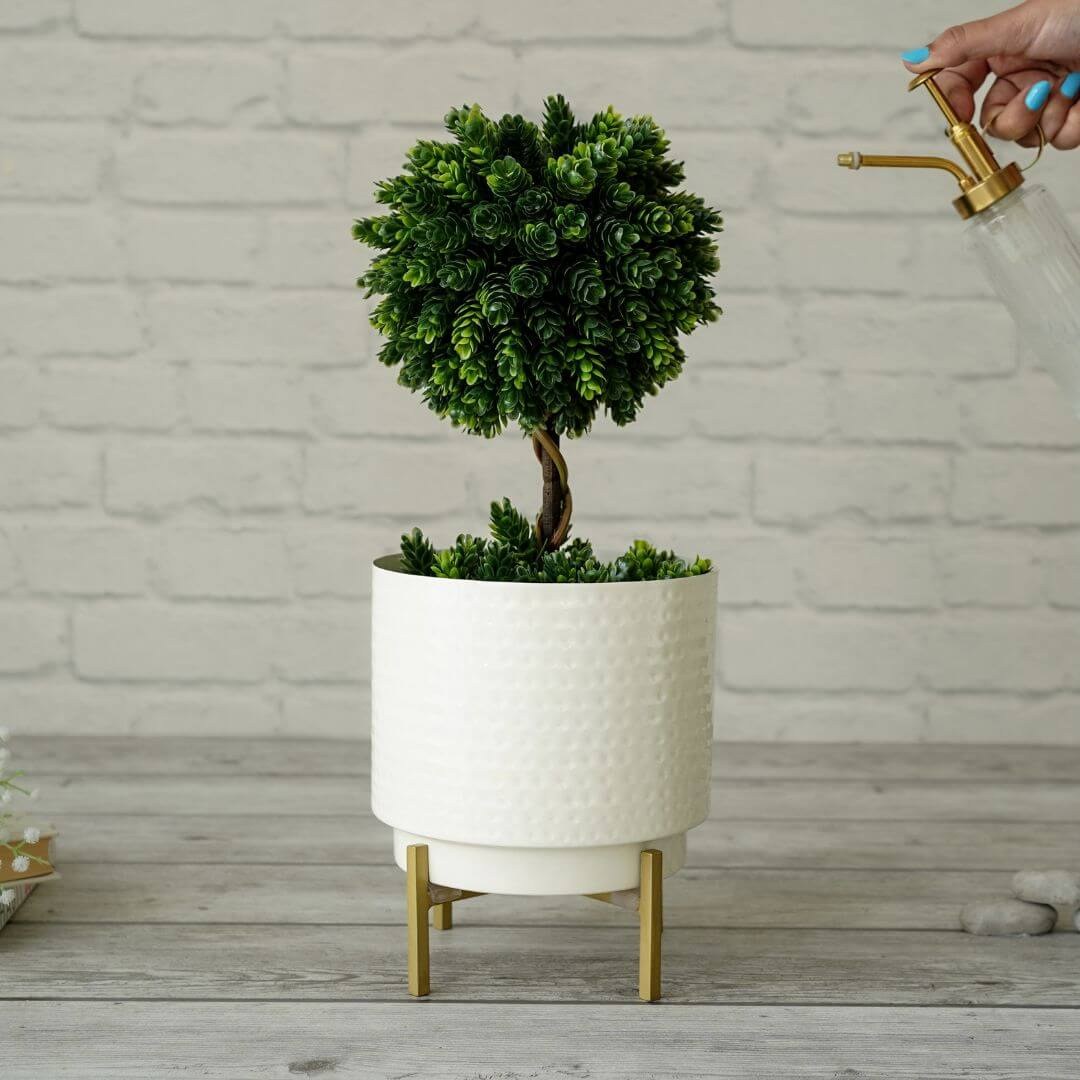

In [24]:
import requests
import glob
from io import BytesIO
from PIL import Image

def image_grid(imgs, rows, cols):
  #assert len(imgs) == rows*cols

  w, h = imgs.size
  grid = Image.new('RGB', size=(cols*w, rows*h))
  grid_w, grid_h = grid.size

  #for i, img in enumerate(imgs):
  grid.paste(imgs, box=(0%cols*w, 0//cols*h))
  return grid

images = Image.open('/content/hPZQhuc.jpeg').convert("RGB")
save_path = "./my_concept"
if not os.path.exists(save_path):
  os.mkdir(save_path)
i = 0
images.save(f"{save_path}/{i}.jpeg")
image_grid(images, 1, 1)

In [25]:
#@title Settings for your newly created concept

instance_prompt = "<plant-pot> pot"
prior_preservation = True
prior_preservation_class_prompt = "a photo of plant pot"

# number of class images to generate
num_class_images = 1
sample_batch_size = 1
# it determines the influence of prior loss in overall loss
# it is done to ensure model doesn't repeat old characters
prior_loss_weight = 0.5
prior_preservation_class_folder = "./class_images"
class_data_root = prior_preservation_class_folder
class_prompt = prior_preservation_class_prompt

In [26]:
#@title Setup the Classes
from pathlib import Path
from torchvision import transforms

class DreamBoothDataset(Dataset):
  def __init__(
      self,
      instance_data_root,
      instance_prompt,
      tokenizer,
      class_data_root=None,
      class_prompt=None,
      size = 512,
      center_crop=False):
    self.size = size
    self.center_crop = center_crop
    self.tokenizer = tokenizer

    self.instance_data_root = Path(instance_data_root)
    if not self.instance_data_root.exists():
      raise ValueError("instance images root doesn't exist.")

    self.instance_images_path = list(Path(instance_data_root).iterdir())
    self.num_instance_images = len(self.instance_images_path)
    self.instance_prompt = instance_prompt
    self._length = self.num_instance_images

    if class_data_root is not None:
      self.class_data_root = Path(class_data_root)
      self.class_data_root.mkdir(parents=True, exist_ok=True)
      self.class_images_path = list(Path(class_data_root).iterdir())
      self.num_class_images = len(self.class_images_path)
      self._length = max(self.num_class_images, self.num_instance_images)
      self.class_prompt = class_prompt

    else:
      self.class_data_root = None

    self.image_transforms = transforms.Compose(
        [
            transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(size) if center_crop else transforms.randomCrop(size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ]
    )

  def __len__(self):
    return self._length


  def __getitem__(self, index):
    example = {}
    instance_image = Image.open(self.instance_images_path[index % self.num_instance_images])
    if not instance_image.mode == "RGB":
      instance_image = instance_image.convert("RGB")
    example["instance_images"] = self.image_transforms(instance_image)
    example["instance_prompt_ids"] = self.tokenizer(
        self.instance_prompt,
        padding="do_not_pad",
        truncation=True,
        max_length = self.tokenizer.model_max_length,
    ).input_ids

    if self.class_data_root:
      class_image = Image.open(self.class_images_path[index % self.num_class_images])
      if not class_image.mode == "RGB":
        class_image = class_image.convert("RGB")
      example["class_images"] = self.image_transforms(class_image)
      example["class_prompt_ids"] = self.tokenizer(
          self.class_prompt,
          padding="do_not_pad",
          truncation=True,
          max_length = self.tokenizer.model_max_length
      ).input_ids


    return example


class PromptDataset(Dataset):
  def __init__(self, prompt, num_samples):
    self.prompt = prompt
    self.num_samples = num_samples

  def __len__(self):
    return self.num_samples

  def __getitem__(self, index):
    example = {}
    example["prompt"] = self.prompt
    example["index"] = index
    return example

In [27]:
#@title Generate Class Images
import gc
if(prior_preservation):
  class_images_dir = Path(class_data_root)
  if not class_images_dir.exists():
    class_images_dir.mkdir(parents=True)
  cur_class_images = len(list(class_images_dir.iterdir()))

  if cur_class_images < num_class_images:
    pipeline = StableDiffusionPipeline.from_pretrained(
        pretrained_model_name_or_path, revision="fp16", torch_dtype=torch.float16
    ).to("cuda")
    pipeline.enable_attention_slicing()
    pipeline.set_progress_bar_config(disable=True)

    num_new_images = num_class_images - cur_class_images
    print(f"Number of class images to sample: {num_new_images}.")

    sample_dataset = PromptDataset(class_prompt, num_new_images)
    sample_dataloader = torch.utils.data.DataLoader(sample_dataset, batch_size=sample_batch_size,
                                                    )

    for example in tqdm(sample_dataloader, desc="Generating class images"):
      images = pipeline(example["prompt"]).images

      for i, image in enumerate(images):
        image.save(class_images_dir / f"{example['index'][i] + cur_class_images}.jpg")

    pipeline = None
    gc.collect()
    del pipeline
    with torch.no_grad():
      torch.cuda.empty_cache()

In [28]:
#@title Load the Stable Diffusion model
# Load models and create wrapper for stable diffusion
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder"
)

vae = AutoencoderKL.from_pretrained(
    pretrained_model_name_or_path, subfolder="vae"
)

unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="unet"
)

tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer"
)

In [29]:
#@title Setting up all training args
from argparse import Namespace
save_path = "./my_concept"
args = Namespace(
    pretrained_model_name_or_path = pretrained_model_name_or_path,
    resolution = vae.sample_size,
    center_crop = True,
    train_text_encoder = False,
    instance_data_dir = save_path,
    instance_prompt = instance_prompt,
    learning_rate = 5e-06,
    max_train_steps = 300,
    save_steps = 50,
    train_batch_size = 1,
    gradient_accumulation_steps=2,
    max_grad_norm=1.0,
    mixed_precision = "fp16",
    gradient_checkpointing = True,
    use_8bit_adam = True,
    seed = 34345554,
    with_prior_preservation = prior_preservation,
    prior_loss_weight = prior_loss_weight,
    sample_batch_size = 2,
    class_data_dir=prior_preservation_class_folder,
    class_prompt=prior_preservation_class_prompt,
    num_class_images=num_class_images,
    lr_scheduler="constant",
    lr_warmup_steps=100,
    output_dir="dreambooth-concept",
)

<ipython-input-29-cbb3ee00637e>:6: FutureWarning: Accessing config attribute `sample_size` directly via 'AutoencoderKL' object attribute is deprecated. Please access 'sample_size' over 'AutoencoderKL's config object instead, e.g. 'unet.config.sample_size'.
  resolution = vae.sample_size,


In [34]:
#@title Training function
from accelerate.utils import set_seed
def training_function(text_encoder, vae, unet):
  logger = get_logger(__name__)

  set_seed(args.seed)

  accelerator = Accelerator(
      gradient_accumulation_steps=args.gradient_accumulation_steps,
      mixed_precision=args.mixed_precision
  )

  if args.train_text_encoder and args.gradient_accumulation_steps > 1 and accelerator.num_processes > 1:
    raise ValueError(
        "Gradient accumulation is not supported when training the text encoder in distributed training. "
        "Please set gradient_accumulation_steps to 1. This feature will be supported in the future."
    )


  vae.requires_grad_(False)
  if not args.train_text_encoder:
    text_encoder.requires_grad_(False)

  if args.gradient_checkpointing:
    unet.enable_gradient_checkpointing()
    if args.train_text_encoder:
      text_encoder.gradient_checkpointing_enable()

  # use 8bit Adam for lower memory usage or to fine-tune the model in 16GB GPUs
  if args.use_8bit_adam:
    optimizer_class = bnb.optim.AdamW8bit
  else:
    optimizer_class = torch.optim.AdamW

  params_to_optimize = (
      itertools.chain(unet.parameters(), text_encoder.parameters()) if args.train_text_encoder else unet.parameters()
  )

  optimizer = optimizer_class(
      params_to_optimize,
      lr=args.learning_rate
  )

  noise_scheduler = DDPMScheduler.from_config(args.pretrained_model_name_or_path, subfolder="scheduler")

  train_dataset = DreamBoothDataset(
      instance_data_root=args.instance_data_dir,
      instance_prompt=args.instance_prompt,
      class_data_root=args.class_data_dir if args.with_prior_preservation else None,
      class_prompt=args.class_prompt,
      tokenizer=tokenizer,
      size=args.resolution,
      center_crop=args.center_crop
  )


  def collate_fn(examples):
    input_ids = [example["instance_prompt_ids"] for example in examples]
    pixel_values = [example["instance_images"] for example in examples]

    # concat class and instance examples for prior preservation
    if args.with_prior_preservation:
      input_ids += [example["class_prompt_ids"] for example in examples]
      pixel_values += [example["class_images"] for example in examples]

    pixel_values = torch.stack(pixel_values)
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

    input_ids = tokenizer.pad(
        {"input_ids": input_ids},
        padding="max_length",
        return_tensors="pt",
        max_length=tokenizer.model_max_length
    ).input_ids

    batch = {
        "input_ids": input_ids,
        "pixel_values": pixel_values,
    }
    return batch


  train_dataloader = torch.utils.data.DataLoader(
      train_dataset, batch_size=args.train_batch_size, shuffle=True, collate_fn=collate_fn
  )

  lr_scheduler = get_scheduler(
      args.lr_scheduler,
      optimizer=optimizer,
      num_warmup_steps=args.lr_warmup_steps * args.gradient_accumulation_steps,
      num_training_steps = args.max_train_steps * args.gradient_accumulation_steps
  )

  if args.train_text_encoder:
    unet, text_encoder, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        unet, text_encoder, optimizer, train_dataloader, lr_scheduler
    )
  else:
    unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        unet, optimizer, train_dataloader, lr_scheduler
    )


  weight_dtype = torch.float32
  if accelerator.mixed_precision == "fp16":
    weight_dtype = torch.float16
  elif accelerator.mixed_precision == "bf16":
    weight_dtype = torch.bfloat16


  # Move text encode and vae to gpu.
  # For mixed precision training we cast the text_encoder and vae weights to half precision
  # as these models are only used for inference, keeping weights in full precision is not required.
  vae.to(accelerator.device, dtype=weight_dtype)
  vae.decoder.to("cpu")
  if not args.train_text_encoder:
    text_encoder.to(accelerator.device, dtype=weight_dtype)

  # We need to recalculate our total training steps as the size of the training dataloader may have changed
  num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
  num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)

  # Train!
  total_batch_size = args.train_batch_size * accelerator.num_processes * args.gradient_accumulation_steps


  logger.info("***** Running training ******")
  logger.info(f"  Num examples = {len(train_dataset)}")
  logger.info(f" Instanteneous batch size per device = {args.train_batch_size}")
  logger.info(f" Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
  logger.info(f" Gradient Accumulation steps = {args.gradient_accumulation_steps}")
  logger.info(f" Total optimization steps = {args.max_train_steps}")

  # only show the progress bar once on each machine
  progress_bar = tqdm(range(args.max_train_steps), disable= not accelerator.is_local_main_process)

  progress_bar.set_description("Steps")
  global_step = 0

  for epoch in range(num_train_epochs):
    unet.train()
    for step, batch in enumerate(train_dataloader):
      with accelerator.accumulate(unet):
        # Convert images to latent space
        latents = vae.encode(batch["pixel_values"].to(dtype=weight_dtype)).latent_dist.sample()
        latents = latents*0.18215

        # Sample noise that we'll add to the latents
        noise = torch.randn_like(latents)
        bsz = latents.shape[0]
        # Sample a random timestep for each image
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
        timesteps = timesteps.long()

        # Add noise to the latents according to the noise magnitude at each timestep
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
        timesteps = timesteps.long()

        # Add noise to the latents according to the noise magnitude at each timestep
        # (this is the forward diffusion process)
        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

        # Get the text embedding for conditioning
        encoder_hidden_states = text_encoder(batch["input_ids"])[0]

        # Predict the noise residual
        noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

        # Get the target for loss depending on the prediction type
        if noise_scheduler.config.prediction_type == "epsilon":
          target = noise
        elif noise_scheduler.config.prediction_type == "v_prediction":
          target = noise_scheduler.get_velocity(latents, noise, timesteps)
        else:
          raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

        if args.with_prior_preservation:
          # Chunk the noise and noise_pred into two parts and compute the loss on each part separately
          noise_pred, noise_pred_prior = torch.chunk(noise_pred, 2, dim=0)
          target, target_prior = torch.chunk(target, 2, dim=0)


          # Compute instance loss
          loss = F.mse_loss(noise_pred.float(), target.float(), reduction="none").mean([1, 2, 3])

          # Compute prior loss
          prior_loss = F.mse_loss(noise_pred_prior.float(), target_prior.float(), reduction="mean")

          # Add the prior loss to the instance loss
          loss = loss + args.prior_loss_weight * prior_loss
        else:
          loss = F.mse_loss(noise_pred.float(), target.flost(), reduction="mean")

        accelerator.backward(loss)

        if accelerator.sync_gradients:
          params_to_clip = (
              itertools.chain(unet.parameters(), text_encoder.parameters())
              if args.train_text_encoder
              else unet.parameters()
          )
          accelerator.clip_grad_norm_(unet.parameters(), args.max_grad_norm)
        optimizer.step()
        optimizer.zero_grad()

      # Checks if the accelerator has performed an optimization step behind the scenes
      if accelerator.sync_gradients:
        progress_bar.update(1)
        global_step += 1

        if global_step % args.save_steps == 0:
          if accelerator.is_main_process:
            pipeline = StableDiffusionPipeline.from_pretrained(
                args.pretrained_model_name_or_path,
                unet=accelerator.unwrap_model(unet),
                text_encoder = accelerator.unwrap_model(text_encoder),
            )
            save_path = os.path.join(args.output_dir, f"checkpoint-{global_step}")
            pipeline.save_pretrained(save_path)

      logs = {"loss": loss.detach().item()}
      progress_bar.set_postfix(**logs)

      if global_step >= args.max_train_steps:
        break


    accelerator.wait_for_everyone()

  # Create the pipeline using th etrained modules and save it.
  if accelerator.is_main_process:
    pipeline = StableDiffusionPipeline.from_pretrained(
        args.pretrained_model_name_or_path,
        unet=accelerator.unwrap_model(unet),
        text_encoder = accelerator.unwrap_model(text_encoder)
    )
    pipeline.save_pretrained(args.output_dir)

In [35]:
# @title Run training.
import accelerate
accelerate.notebook_launcher(training_function, args=(text_encoder, vae, unet))
for param in itertools.chain(unet.parameters(), text_encoder.parameters()):
  if param.grad is not None:
    del param.grad # free some memory
  torch.cuda.empty_cache()

Launching training on one GPU.


/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:245: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/300 [00:00<?, ?it/s]

model_index.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [36]:
#@title Set up the pipeline
from diffusers import DPMSolverMultistepScheduler
try:
    pipe
except NameError:
    pipe = StableDiffusionPipeline.from_pretrained(
        args.output_dir,
        scheduler = DPMSolverMultistepScheduler.from_pretrained(args.output_dir, subfolder="scheduler"),
        torch_dtype=torch.float16,
    ).to("cuda")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [37]:
#@title Run the Stable Diffusion pipeline with interactive UI Demo on Gradio
import gradio as gr

def inference(prompt, num_samples):
    all_images = []
    images = pipe(prompt, num_images_per_prompt=num_samples, num_inference_steps=25).images
    all_images.extend(images)
    return all_images

with gr.Blocks() as demo:
    with gr.Row():
        with gr.Column():
            prompt = gr.Textbox(label="prompt")
            samples = gr.Slider(label="Samples",value=1)
            run = gr.Button(value="Run")
        with gr.Column():
            gallery = gr.Gallery(show_label=False)

    run.click(inference, inputs=[prompt,samples], outputs=gallery)
    gr.Examples([["a pot plant in a desert", 1,1]], [prompt,samples], gallery, inference, cache_examples=False)


demo.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://c94802f1062e7094db.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
